# Proyecto 2
## RSNA 2022 Cervical Spine Fracture Detection
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Data Science**

# Inferencia de Vertebras Cervicales con Random Forest
---

## Integrantes
- Gustavo Gonzalez
- Pablo Orellana
- Diego Leiva
- Maria Ramirez

---

## Librerias

In [1]:
# Manejo de datos
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y evaluación
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix

# Modelos
from sklearn.ensemble import RandomForestClassifier

## Carga de Datos y Metadatos

In [2]:
# Carga de datos a partir de los archivos CSV
meta_seg = pd.read_csv('metadata/segmentation_metadata.csv')
meta_train = pd.read_csv('metadata/dicom_metadata.csv')
train_df = pd.read_csv('data/train.csv')
bbox_df = pd.read_csv('data/train_bounding_boxes.csv')

## Random Forest Classifier

### Relación de Corte

In [3]:
# Agrupación de datos por estudio y corte
slice_max_seg = meta_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
# Creación de una nueva columna con la relación entre el corte y el máximo de cortes por estudio
meta_seg['SliceRatio'] = 0
meta_seg['SliceRatio'] = meta_seg['Slice']/meta_seg['StudyInstanceUID'].map(slice_max_seg)

### Caracteristicas y Objetivos

In [4]:
# Características y objetivos a utilizar
features = ['SliceRatio','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']

targets = ['C1','C2','C3','C4','C5','C6','C7']

# Creación de los conjuntos de datos
X = meta_seg[['StudyInstanceUID']+features]
y = meta_seg[targets]

### Split del dataset

In [5]:
# Se utiliza GroupKFold para dividir los datos en conjuntos de entrenamiento y validación
# de manera que los datos de un mismo paciente no se encuentren en ambos conjuntos
gkf = GroupKFold(n_splits=5)
(train_idx, valid_idx) = next(gkf.split(X, y, groups = X['StudyInstanceUID']))

# Conjunto de entrenamiento
X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx,:]

# Conjunto de validación
X_valid, y_valid = X.iloc[valid_idx,:], y.iloc[valid_idx,:]

# Eliminación de la columna 'StudyInstanceUID' para evitar errores en el entrenamiento
X_train = X_train.drop('StudyInstanceUID', axis=1)
X_valid = X_valid.drop('StudyInstanceUID', axis=1)

### Entrenamiento

In [6]:
# Entrenamiento de un modelo de Random Forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

### Evaluacion de rendimiento

In [7]:
# Realización de predicciones
y_preds = clf.predict(X_valid)

# Evaluación de las predicciones del modelo
total_acc = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')

# Obtener la precisión global
print('')
print(f'Overall accuracy: {total_acc} %')

Accuracy of C1: 0.8910354177258092 %
Accuracy of C2: 0.8847652940179631 %
Accuracy of C3: 0.9020504999152686 %
Accuracy of C4: 0.8930689713607863 %
Accuracy of C5: 0.8861209964412812 %
Accuracy of C6: 0.867141162514828 %
Accuracy of C7: 0.8561260803253686 %

Overall accuracy: 0.8829012031859008 %


### Importancia de Caracteristicas

In [8]:
# Crear un dataframe con las características y su importancia en el modelo
pd.DataFrame({'Feature':features, 'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.575552
4,ImagePositionPatient_z,0.210009
2,ImagePositionPatient_x,0.090593
3,ImagePositionPatient_y,0.089352
1,SliceThickness,0.034495


### Matrices de Confusion

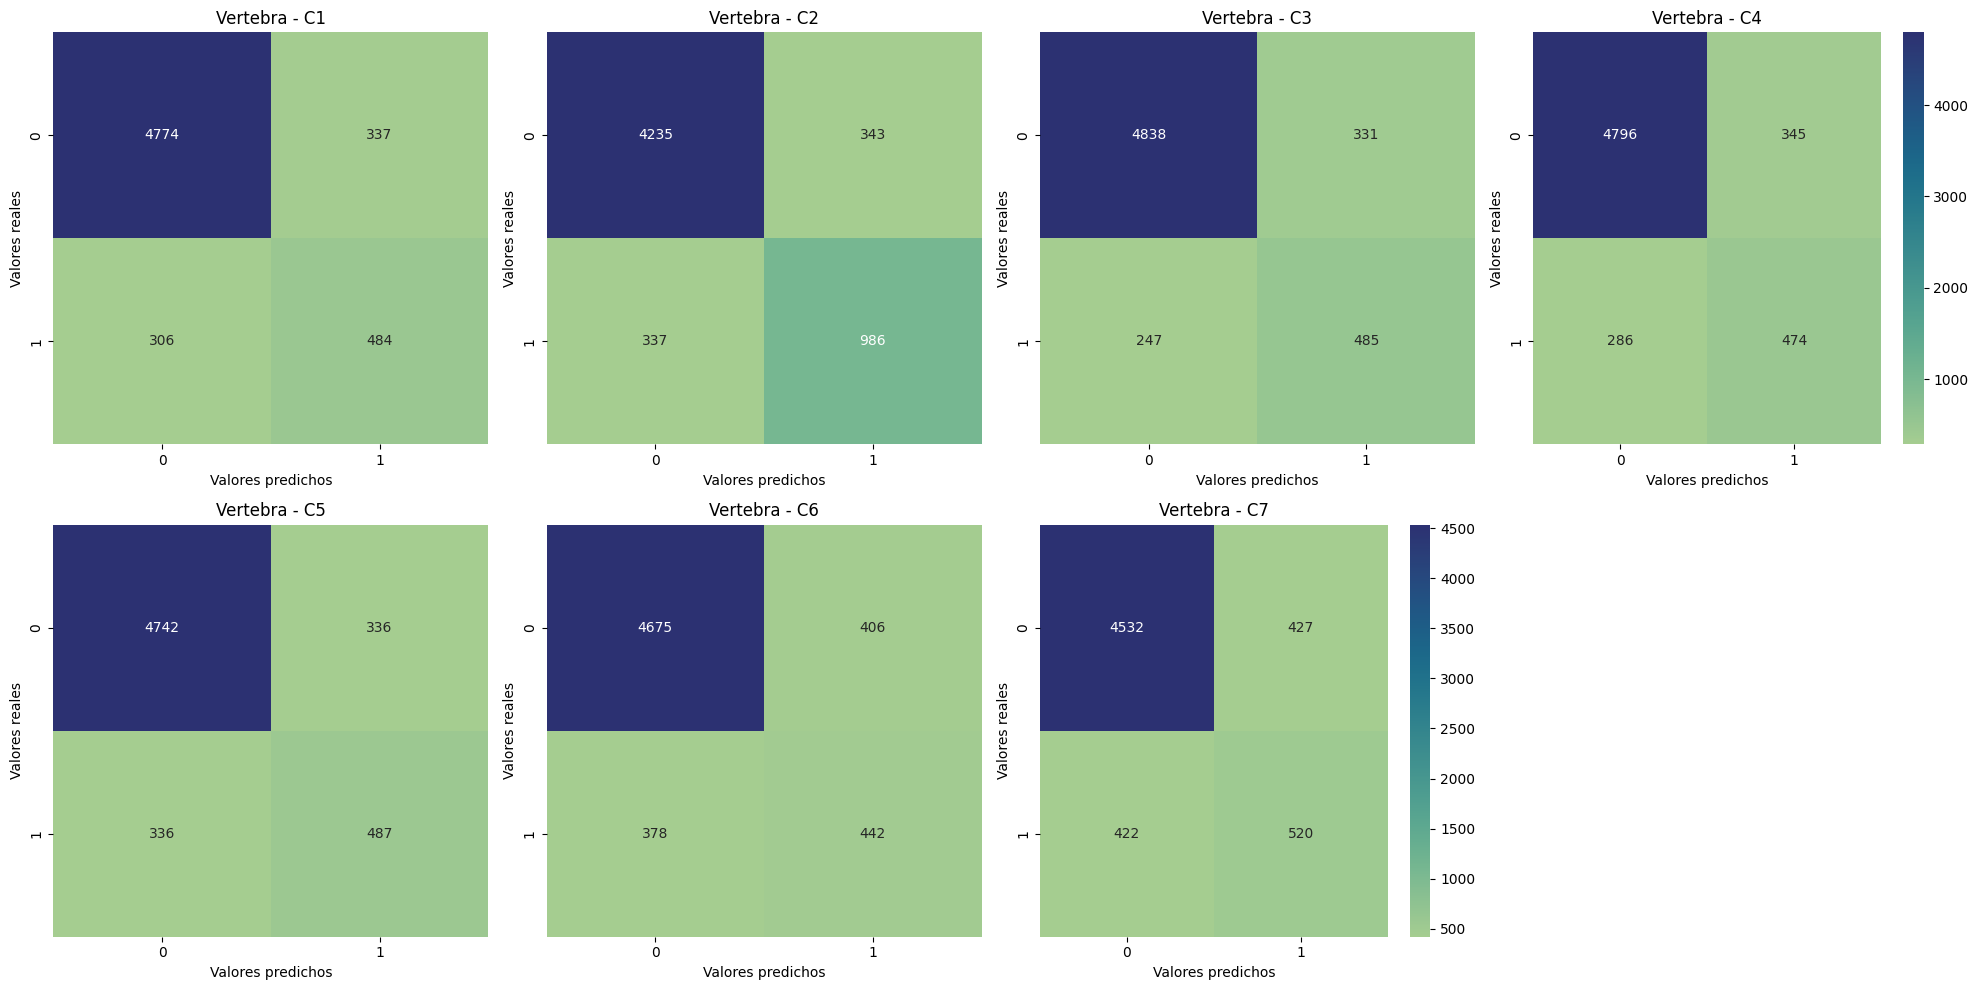

In [9]:
# Obtener predicciones
preds = clf.predict(X_valid)

# Configuración de la figura
fig = plt.figure(figsize=(20,10))
# Creación de una matriz de subgráficos
for i in range(7):
    # Obtención de la matriz de confusión
    cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
    plt.subplot(2,4,i+1)
    # Alineacion de Matrices de confusión
    CBAR=False
    if (i==3) or (i==6):
        CBAR=True
    # Creación de un mapa de calor
    sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='crest')
    plt.xlabel('Valores predichos')
    plt.ylabel('Valores reales')
    plt.title(f'Vertebra - C{i+1}')
fig.tight_layout()
plt.show()

### Inferencia para todos los pacientes

In [10]:
# Calcular la relación de cortes (para generalizar mejor)
slice_max_train = meta_train.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_train['SliceRatio'] = 0
meta_train['SliceRatio'] = meta_train['Slice']/meta_train['StudyInstanceUID'].map(slice_max_train)

# Inicializar targets en 0
meta_train[targets]=0

# Predecir las vertebras en el conjunto de datos de entrenamiento
meta_train[targets] = clf.predict(meta_train[features])

# Sabemos que las imágenes con segmentaciones tienen objetivos 100% precisos, así que los ponemos de vuelta
meta_train.loc[meta_train['StudyInstanceUID'].isin(meta_seg['StudyInstanceUID']),targets] = meta_seg[targets].values

In [11]:
# Visualización de los datos
meta_train.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10001,4,512,512,0.625,-52.308,-27.712,5.407,0.014925,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10001,5,512,512,0.625,-52.308,-27.712,4.782,0.018657,0,0,0,0,0,0,0


### Exportacion de Clasificacion de Vertebras

In [12]:
# Almacenar los datos en un archivo CSV
meta_train.to_csv('metadata/vertebrae_metadata_RF.csv', index=False)

### Distribuciones

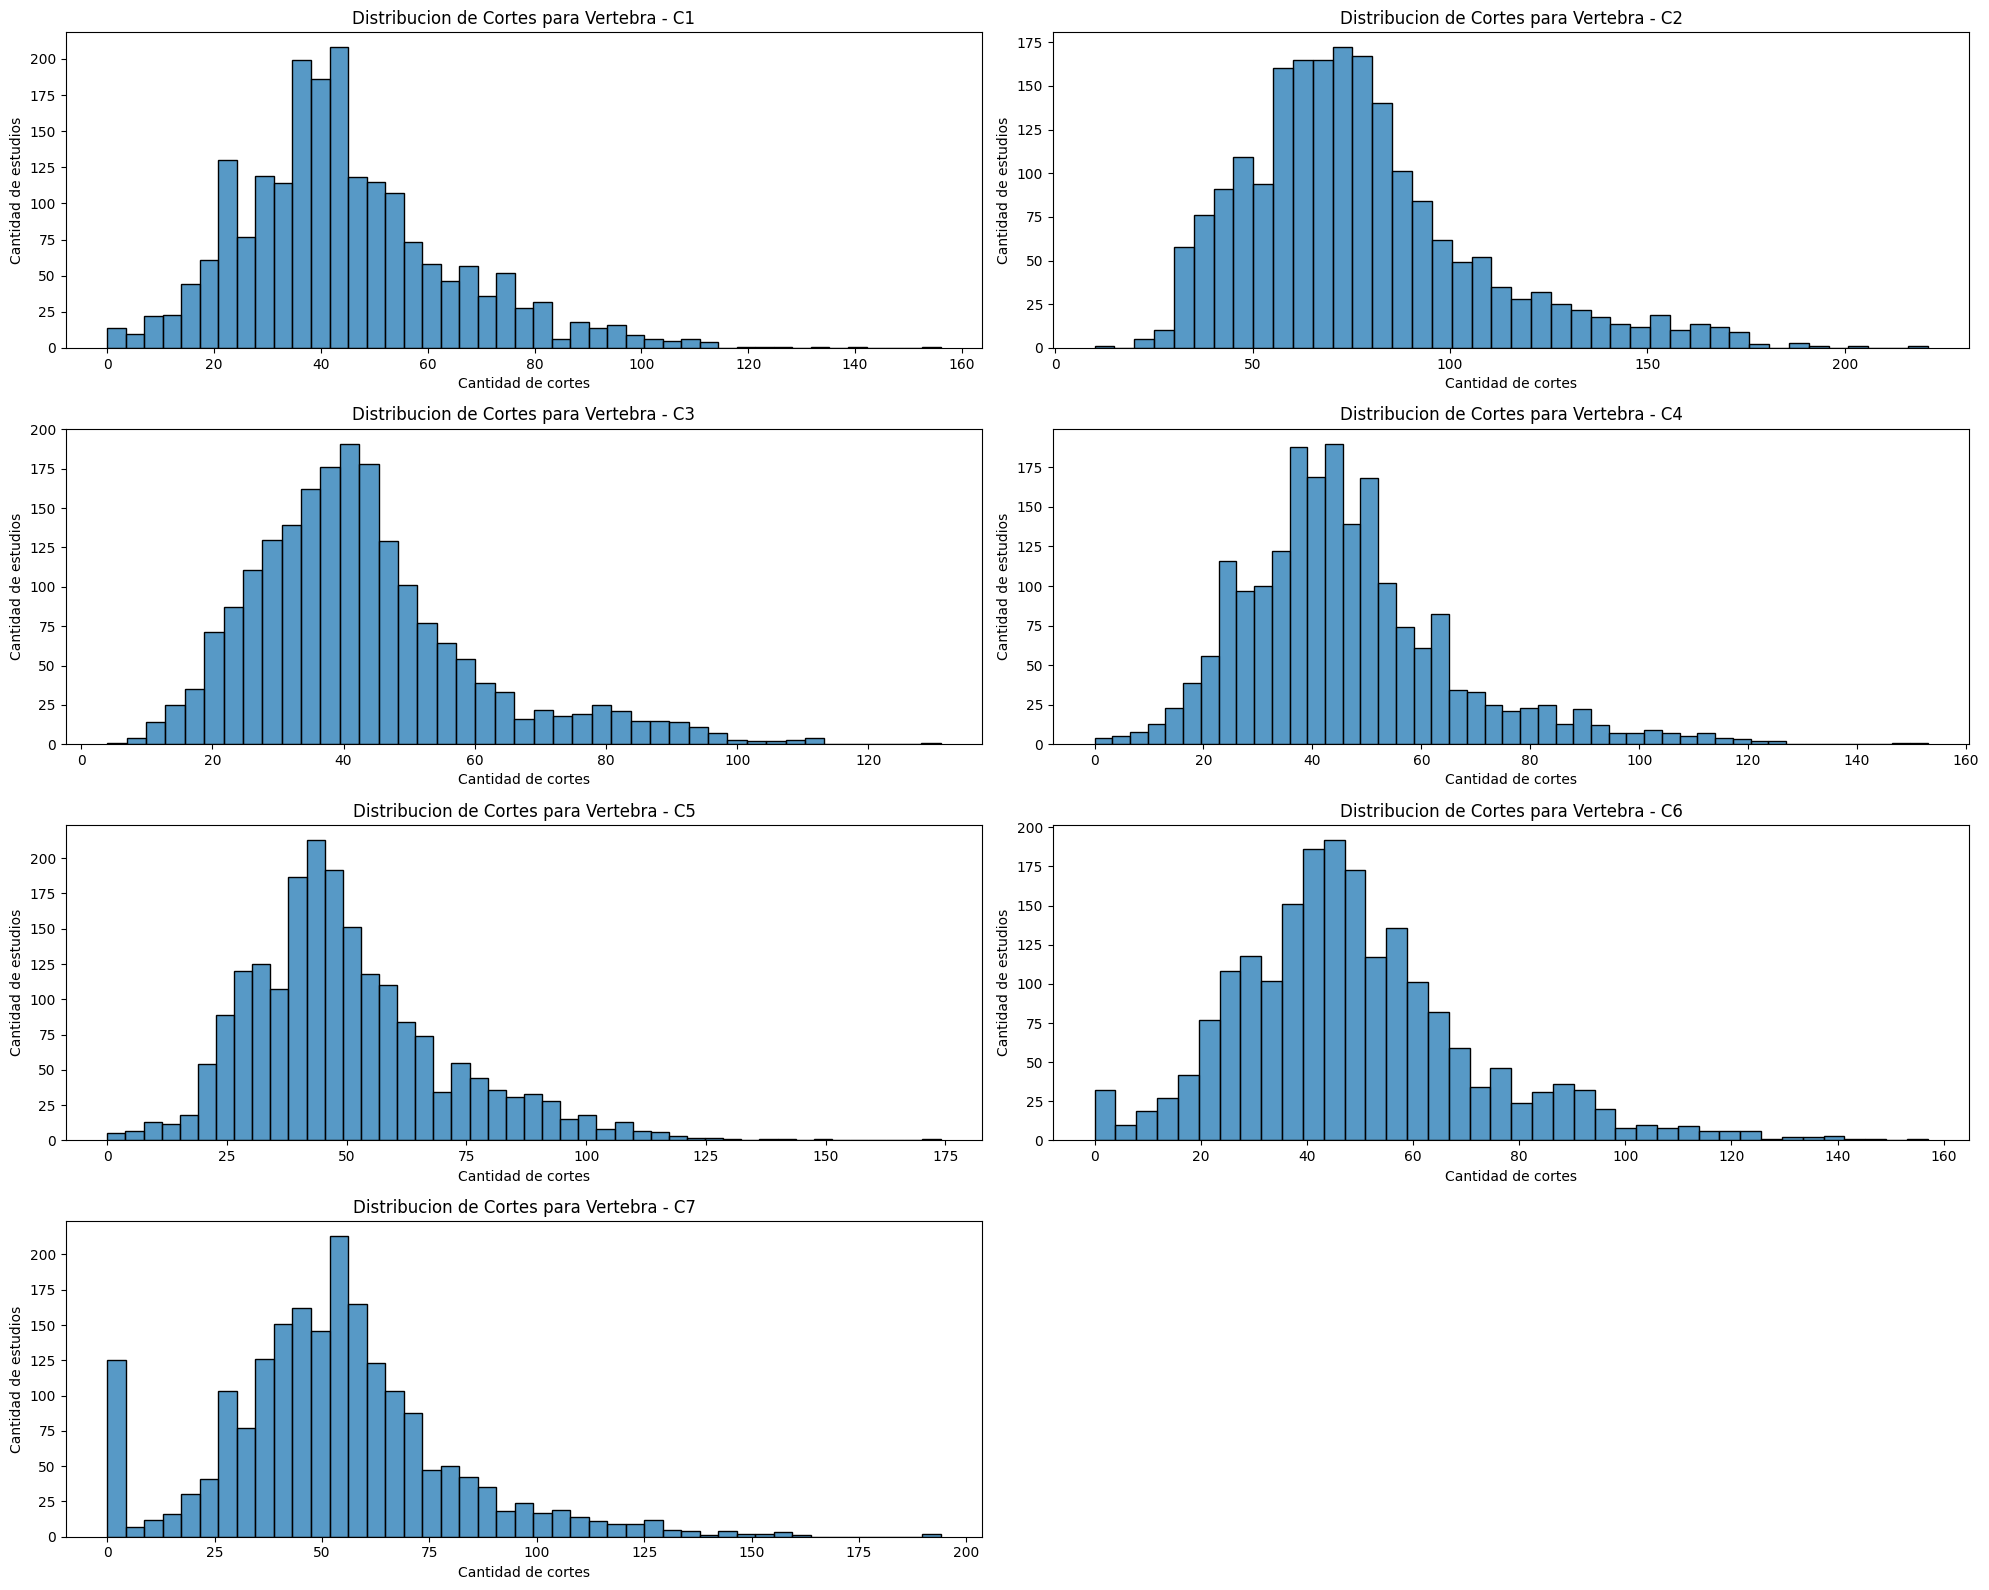

In [13]:
# Visualización de la distribución de las vertebras
fig = plt.figure(figsize=(20,16))
# Creación de una matriz de subgráficos
for i, Cx in enumerate(targets):
    # Creación de un histograma
    plt.subplot(4,2,i+1)
    sns.histplot(meta_train.groupby('StudyInstanceUID')[Cx].sum())
    plt.title(f'Distribucion de Cortes para Vertebra - {Cx}')
    plt.xlabel('Cantidad de cortes')
    plt.ylabel('Cantidad de estudios')
fig.tight_layout()